

╒═════════════════════════╤══════════════╕
│ SIT calibration point   │ plot point   │
╞═════════════════════════╪══════════════╡
│ top left                │ bottom right │
├─────────────────────────┼──────────────┤
│ top right               │ bottom left  │
├─────────────────────────┼──────────────┤
│ center                  │ center       │
├─────────────────────────┼──────────────┤
│ bottom left             │ top right    │
├─────────────────────────┼──────────────┤
│ bottom right            │ top left     │
╘═════════════════════════╧══════════════╛


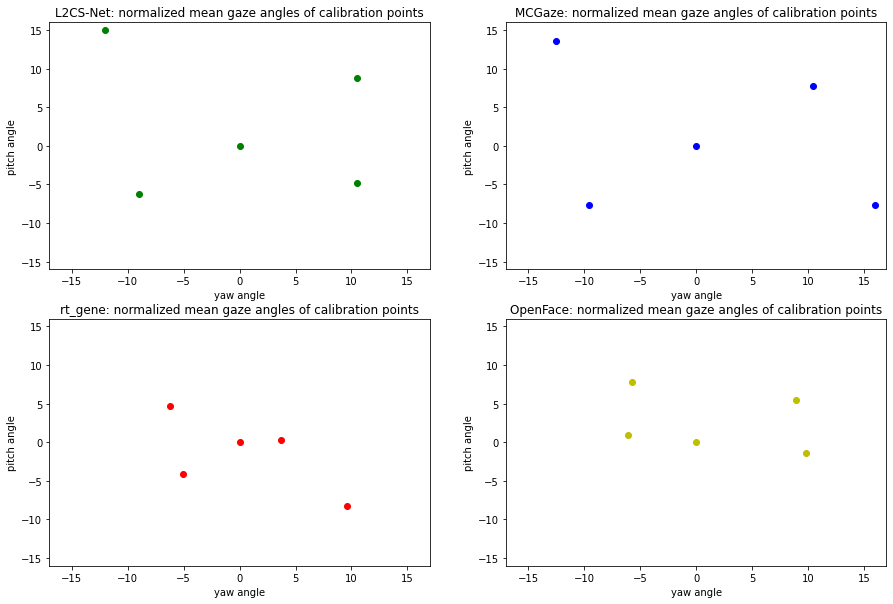

In [4]:
import csv
import math
from matplotlib import pyplot as plt
from tabulate import tabulate


#
# ATTENTION: The below functions are just copied from MethodValidation.ipynb.
# If you want to change anything then do the changes over there and copy it into here anew!
#

def get_first_and_last_frame_by_calibration_point():

    first_and_last_frame_by_calibration_point = dict()
    
    with open('../Step_3/CalibrationFrames.csv') as csvfile:
        
        file_content = csv.DictReader(csvfile)

        for row in file_content:
            first_and_last_frame_by_calibration_point[int(row['calibration point'])] = {
                'first frame': int(row['first frame']),
                'last frame': int(row['last frame'])
            }

    return first_and_last_frame_by_calibration_point

def rad_to_deg(value_in_radians):
    return value_in_radians * 180 / math.pi

def get_estimated_yaw_and_pitch_by_calibration_point(gaze_estimation_method):

    estimated_yaw_and_pitch_by_calibration_point = dict()
    first_and_last_frame_by_calibration_point = get_first_and_last_frame_by_calibration_point()

    with open('../Step_3/EstimatedGaze/' + gaze_estimation_method + '.csv') as csvfile:
        
        file_rows = list(csv.DictReader(csvfile))

        for calibration_point in first_and_last_frame_by_calibration_point:
            estimated_yaw_and_pitch_by_calibration_point[calibration_point] = []

            for frame_index in range(
                first_and_last_frame_by_calibration_point[calibration_point]['first frame'] - 1,
                first_and_last_frame_by_calibration_point[calibration_point]['last frame']
            ):
                estimated_yaw_and_pitch_by_calibration_point[calibration_point].append(
                    {
                        'yaw': rad_to_deg(float(file_rows[frame_index]['yaw in radians'])),
                        # in case of rt_gene I messed up the adjustment to OpenFace convention, hence need to negate pitch
                        'pitch': rad_to_deg(-float(file_rows[frame_index]['pitch in radians']) if (gaze_estimation_method == 'rt_gene') else float(file_rows[frame_index]['pitch in radians']))
                    }
                )

    return estimated_yaw_and_pitch_by_calibration_point

def calculate_mean_of_estimated_yaw_and_pitch_by_calibration_point(estimated_yaw_and_pitch_by_calibration_point):
    
    mean_of_estimated_yaw_and_pitch_by_calibration_point = dict()

    for calibration_point in estimated_yaw_and_pitch_by_calibration_point:
        sum_yaw = 0.0
        sum_pitch = 0.0
        count_non_nan = 0

        for elem in estimated_yaw_and_pitch_by_calibration_point[calibration_point]:
            # if one of yaw and pitch is nan then the other is too
            if not math.isnan(elem['yaw']):
                sum_yaw += elem['yaw']
                sum_pitch += elem['pitch']
                count_non_nan += 1

        mean_of_estimated_yaw_and_pitch_by_calibration_point[calibration_point] = {
            'yaw': round(sum_yaw / count_non_nan, 3),
            'pitch': round(sum_pitch / count_non_nan, 3)
            }
        
    return mean_of_estimated_yaw_and_pitch_by_calibration_point

#
# end of functions that I copied from MethodValidation.ipynb
#



def plot_normalized_calibration_point_means():

    plt.rcParams["figure.figsize"] = (15,10)
    
    plot_color_by_method = {
        'L2CS-Net': 'g',
        'MCGaze': 'b',
        'rt_gene': 'r',
        'OpenFace': 'y'
    }
    
    print('\n')
    print(
        tabulate(
            [
                ['top left', 'bottom right'],
                ['top right', 'bottom left'],
                ['center', 'center'],
                ['bottom left', 'top right'],
                ['bottom right', 'top left']
            ],
            headers=['SIT calibration point', 'plot point'],
            tablefmt='fancy_grid'
        )
    )
    
    plot_number = 1

    for method in ['L2CS-Net', 'MCGaze', 'rt_gene', 'OpenFace']:

        estimated_yaw_and_pitch_by_calibration_point = get_estimated_yaw_and_pitch_by_calibration_point(method)
        mean_of_estimated_yaw_and_pitch_by_calibration_point = calculate_mean_of_estimated_yaw_and_pitch_by_calibration_point(estimated_yaw_and_pitch_by_calibration_point)

        yaw_means_normalized = []
        pitch_means_normalized = []

        for calibration_point in mean_of_estimated_yaw_and_pitch_by_calibration_point:
            
            yaw_means_normalized.append(
                mean_of_estimated_yaw_and_pitch_by_calibration_point[calibration_point]['yaw'] -
                mean_of_estimated_yaw_and_pitch_by_calibration_point[3]['yaw']
            )
            
            pitch_means_normalized.append(
                mean_of_estimated_yaw_and_pitch_by_calibration_point[calibration_point]['pitch'] -
                mean_of_estimated_yaw_and_pitch_by_calibration_point[3]['pitch']
            )
            
        #print('@@@' + method + '@@@\nyaw_means_normalized:', yaw_means_normalized, '\npitch_means_normalized:', pitch_means_normalized)
            
        plt.subplot(2, 2, plot_number)
        plt.title(method + ': normalized mean gaze angles of calibration points')
        plt.scatter(yaw_means_normalized, pitch_means_normalized, color=plot_color_by_method[method])
        ax = plt.gca()
        ax.set_xlim([-17, 17])
        ax.set_ylim([-16, 16])
        plt.xlabel('yaw angle')
        plt.ylabel('pitch angle')
        
        plot_number += 1

    plt.show()
    


methods = ['L2CS-Net', 'MCGaze', 'rt_gene', 'OpenFace']
plot_normalized_calibration_point_means()

In [2]:
from tabulate import tabulate


#
# IMPORTANT NOTE:
# Everything prefixed with '###' belongs to code that shows how the point shrinking works.
# I didn't want to delete it, because it might be useful in the future.
#


###tmp_shrunken_points_per_method = []


# First returned value indicates how closely the rectangle formed by the calibration point's
# gaze estimation means (excluding the center) resembles the SIT rectangle on the computer screen.
# The smaller this value is the better (an exact match of the SIT calibration in- or deflated rectangle
# would result in the value 0.0).
# Second returned value tells how sensitive the method is to changes in gaze angle. Given that OpenFace
# is bad at this the value for a decent method should be greater than the one for OpenFace.
def compute_calibration_rect_similarity_and_sensitivity(points):
    def shrink_distance(y_shrinkage):

        calibration_rectangle_width = 1977.046875 - 40.953125
        calibration_rectangle_height = 1209.046875 - 40.953125
        # If we shrink the y-coordinate of calibration point's mean gaze estimation by n (y - n), then
        # we need to shrink the x-coordinate by x_to_y_ratio times n (x - x_to_y_ratio*n). "Shrink" thereby
        # means to bring the point closer to the normalized center calibration point's gaze estimation mean,
        # which is at (x, y) = (0, 0).
        x_to_y_ratio = calibration_rectangle_width / calibration_rectangle_height
        
        signums = [
            {'x':1, 'y':-1},
            {'x':-1, 'y':-1},
            {'x':1, 'y':1},
            {'x':-1, 'y':1}
        ]

        result = 0.0

        for i, signum in enumerate(signums):
            result += math.sqrt(
                pow(points[i][0] - signum['x'] * x_to_y_ratio * y_shrinkage, 2) +
                pow(points[i][1] - signum['y'] * y_shrinkage, 2)
            )
            
            ###tmp_shrunken_points_per_method[-1][0].append(points[i][0] - signum['x'] * x_to_y_ratio * y_shrinkage)
            ###tmp_shrunken_points_per_method[-1][1].append( points[i][1] - signum['y'] * y_shrinkage)
            
        return result
    
    
    ###tmp_shrunken_points_per_method.append([[], []])
    
    
    # Judging by the plots from method comparison, we know that y-shrinkage values [0, 0.01, ..., 49.99]
    # are definitely enough to find the (approximated) minimum.
    min_y_shrinkage = min([float(i)/100 for i in range(0, 5000)], key=shrink_distance)
    # Minimal distance to the rectangle, whereby "distance to the rectangle" refers to the sum of
    # distances from origin to each edge for the given y-shrinkage.
    min_of_summed_distances_to_edges = shrink_distance(min_y_shrinkage)
    
    return min_of_summed_distances_to_edges, min_y_shrinkage


similarities_to_calibration_rectangle = []
sensitivities = []

# The index iiii is only used if the code prefixed with '###' is outcommented.
for iiii, method in enumerate(methods):
    estimated_yaw_and_pitch_by_calibration_point = get_estimated_yaw_and_pitch_by_calibration_point(method)
    mean_of_estimated_yaw_and_pitch_by_calibration_point = calculate_mean_of_estimated_yaw_and_pitch_by_calibration_point(estimated_yaw_and_pitch_by_calibration_point)

    yaw_pitch_means_normalized = []

    for i, calibration_point in enumerate(mean_of_estimated_yaw_and_pitch_by_calibration_point):
        
        if i == 2:
            # skip center calibration point
            continue
            
        yaw_pitch_means_normalized.append([
            mean_of_estimated_yaw_and_pitch_by_calibration_point[calibration_point]['yaw'] -
            mean_of_estimated_yaw_and_pitch_by_calibration_point[3]['yaw'],
            mean_of_estimated_yaw_and_pitch_by_calibration_point[calibration_point]['pitch'] -
            mean_of_estimated_yaw_and_pitch_by_calibration_point[3]['pitch']
        ])
    
    similarity_to_calibration_rectangle, sensitivity = compute_calibration_rect_similarity_and_sensitivity(yaw_pitch_means_normalized)
    similarities_to_calibration_rectangle.append(similarity_to_calibration_rectangle)
    sensitivities.append(sensitivity)
    
    
    ###tmp_x = []
    ###tmp_y = []
    
    ###def tmp(points, y_shrinkage):
    ###    calibration_rectangle_width = 1977.046875 - 40.953125
    ###    calibration_rectangle_height = 1209.046875 - 40.953125
    ###    x_to_y_ratio = calibration_rectangle_width / calibration_rectangle_height
    ###    signums = [
    ###        {'x':1, 'y':-1},
    ###        {'x':-1, 'y':-1},
    ###        {'x':1, 'y':1},
    ###        {'x':-1, 'y':1}
    ###    ]
        
    ###    for i, signum in enumerate(signums):
        
    ###        x = points[i][0] - signum['x'] * x_to_y_ratio * y_shrinkage
    ###        y = points[i][1] - signum['y'] * y_shrinkage
    ###        print('x:', x,
    ###              'y:', y)
            
    ###        tmp_x.append(x)
    ###        tmp_y.append(y)
            
    ###plt.scatter(tmp_shrunken_points_per_method[iiii][0], tmp_shrunken_points_per_method[iiii][1])
    ###plt.show()
    ###tmp(yaw_pitch_means_normalized, sensitivity)
    ###plt.scatter(tmp_x, tmp_y)
    ###plt.show()
    
    
print(
    '\n\nSimilarity of rectangle formed by calibration point’s gaze estimation means'
    ' to SIT calibration rectangle and sensitivity to changes in ground truth coordinates'
    ' (larger values indicate greater sensitivity):\n' +
    tabulate(
    [
        ['similarity to calibration rectangle'] + similarities_to_calibration_rectangle,
        ['sensitivity to changes in ground truth'] + sensitivities,
    ],
    headers=['', 'L2CS-Net', 'MCGaze', 'rt_gene', 'OpenFace'],
    tablefmt='fancy_grid'
))



Similarity of rectangle formed by calibration point’s gaze estimation means to SIT calibration rectangle and sensitivity to changes in ground truth coordinates (larger values indicate greater sensitivity):
╒════════════════════════════════════════╤════════════╤══════════╤═══════════╤════════════╕
│                                        │   L2CS-Net │   MCGaze │   rt_gene │   OpenFace │
╞════════════════════════════════════════╪════════════╪══════════╪═══════════╪════════════╡
│ similarity to calibration rectangle    │    14.2238 │  14.4373 │   12.0426 │    14.8964 │
├────────────────────────────────────────┼────────────┼──────────┼───────────┼────────────┤
│ sensitivity to changes in ground truth │     6.23   │   7.34   │    3.7    │     4.89   │
╘════════════════════════════════════════╧════════════╧══════════╧═══════════╧════════════╛




the frames during calibration mouse clicks help with interpretation of plot below:
calibration point | frames
------------------|-------
top left          | 9-38
top right         | 123-157
center            | 206-233
bottom left       | 285-310
bottom right      | 363-389



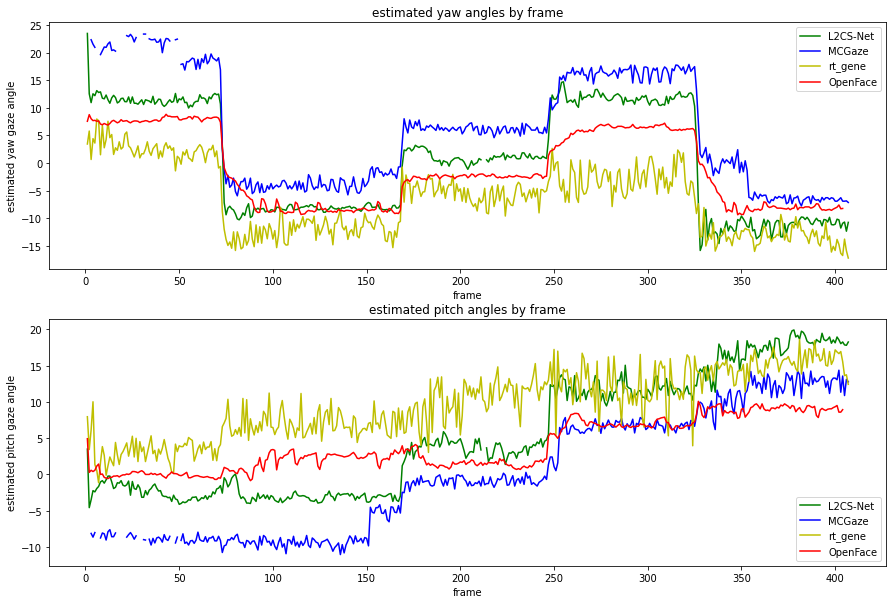

In [3]:
import math
from csv import DictReader
from matplotlib import pyplot as plt
import numpy as np


def rad_to_deg(value_in_radians):
    return value_in_radians * 180 / math.pi

# Returns a list of dictionaries where each dictionary has the keys
# 'yaw in degrees' and 'pitch in degrees'.
# List at index 0 contains gaze estimation for frame 1,
# List at index 1 contains gaze estimation for frame 2,
# etc.
def get_gaze_estimations(gaze_estimation_method):

    gaze_estimations = []

    with open('../Step_3/EstimatedGaze/' + gaze_estimation_method + '.csv') as csvfile:
        
        file_content = list(DictReader(csvfile))
        
        for row in file_content:
            gaze_estimations.append(
                {
                    'yaw in degrees': rad_to_deg(float(row['yaw in radians'])),
                    # in case of rt_gene I messed up the adjustment to OpenFace convention, hence need to negate pitch
                    'pitch in degrees': -rad_to_deg(float(row['pitch in radians'])) if gaze_estimation_method == 'rt_gene' else rad_to_deg(float(row['pitch in radians']))
                }
            )

    return gaze_estimations

def plot_gaze_estimations(methods, gaze_estimations_by_method):
    
    plt.rcParams["figure.figsize"] = (15,10)
    
    plot_color_by_method = {
        'L2CS-Net': 'g',
        'MCGaze': 'b',
        'rt_gene': 'y',
        'OpenFace': 'r'
    }
    
    print('\n\nthe frames during calibration mouse clicks help with interpretation of plot below:')
    print('\033[1m'
          'calibration point | frames\n'
          '------------------|-------\n'
          'top left          | 9-38\n'
          'top right         | 123-157\n'
          'center            | 206-233\n'
          'bottom left       | 285-310\n'
          'bottom right      | 363-389\n'
          '\033[0m')
    
    for method in methods:
        
        yaw_angles = []
        pitch_angles = []
        
        for estimated_gaze in gaze_estimations_by_method[method]:
            yaw_angles.append(estimated_gaze['yaw in degrees'])
            pitch_angles.append(estimated_gaze['pitch in degrees'])
        
        plt.subplot(2, 1, 1)
        plt.title('estimated yaw angles by frame')
        plt.plot(range(1, len(yaw_angles)+1), yaw_angles, label=method, color=plot_color_by_method[method])
        plt.legend(loc="upper right")
        plt.xlabel('frame')
        plt.ylabel('estimated yaw gaze angle')
        
        plt.subplot(2, 1, 2)
        plt.title('estimated pitch angles by frame')
        plt.plot(range(1, len(pitch_angles)+1), pitch_angles, label=method, color=plot_color_by_method[method])
        plt.legend(loc="lower right")
        plt.xlabel('frame')
        plt.ylabel('estimated pitch gaze angle')
    
    plt.show()



gaze_estimations_by_method = dict()

for method in methods:
    gaze_estimations_by_method[method] = get_gaze_estimations(method)
    
plot_gaze_estimations(methods, gaze_estimations_by_method)